# Re-evaluating rhythmic attentional switching

Geoffrey Brookshire

How does attention help to focus perceptual processing on the important parts of a visual scene? Although the neural and perceptual effects of attention were traditionally assumed to be sustained
over time, the field is converging on a dramatically different view: that covert attention rhythmically switches between objects at 3-8 Hz. Here I demonstrate that ubiquitous analyses in this literature
conflate rhythmic oscillations with aperiodic temporal structure. Using computational simulations, I show that the behavioral oscillations reported in this literature could reflect aperiodic dynamics in attention, rather than periodic rhythms. I then propose two analyses (one novel and one widely used in climate science) that discriminate between periodic and aperiodic structure in behavioral time-series. Finally, I apply these alternative analyses to published data-sets, and find no evidence for rhythms in attentional switching after accounting for aperiodic temporal structure.

This notebook illustrates the re-analyses of published data-sets.

## Re-analysis of published data shows spurious oscillations from shuffing-in-time

I re-analyzed the results from 4 published studies:

* Ho et al. (2017): https://ars.els-cdn.com/content/image/1-s2.0-S0960982217313209-mmc2.xlsx
* Davidson et al. (2018): https://figshare.com/projects/Crossmodal_binocular_rivalry_attention_sampling_project/56252
* Senoussi et al. (2019): https://osf.io/2d9sc/?view_only=6ef3f85d9f944d27b23fc7af5a26f087
* Michel et al (2021): https://osf.io/de4bu/

For each external data-set, I re-analyzed every test that relies on shuffling in time. I counted the number of statistically significant and non-significant results reported in the original study, and compared the original results with results obtained by the AR surrogate and robust est. methods.

In [1]:
import os
os.chdir('..')

In [2]:
# Import libraries and set up analyses
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pyreadr
import scipy.io
from analysis_methods.alternatives import ar_surr, robust_est

plt.ion()

data_dir = 'external_data/'
plot_dir = 'plots/'

k_perm = int(1e4)
results = pd.DataFrame({'exp': pd.Series([], dtype=str),
                        'analysis': pd.Series([], dtype=str),
                        'positive': pd.Series([], dtype=int),
                        'negative': pd.Series([], dtype=int)})

np.random.seed(0)  # Make sure results are reproducible

## Ho et al. (2017)

Ho and colleagues tested for behavioral oscillations during auditory perception. They used signal detection theory to examine both sensitivity and criterion, computed separately for sounds in each ear. I found 6 statistical tests in this study that relied on shuffling in time. The significant peak frequencies of those original tests are reproduced here (n.s.: no significant oscillations).
1. Sensitivity, left ear: 6.2 Hz
2. Sensitivity, right ear: 5.6 Hz 
3. Sensitivity, left ear – right ear: 5.9 Hz
4. Sensitivity, left ear + right ear: n.s.
5. Criterion, left ear: 8.7 Hz
6. Criterion, right ear: 7.5 Hz

In [3]:
# Load the data from Ho et al.

# Keep track of the original results reported in the paper
results = results.append({'exp': 'ho_etal2017',
                          'analysis': 'orig',
                          'positive': 5,
                          'negative': 1},
                         ignore_index=True)

fname = 'ho_etal2017.xlsx'

col_names = ['t']
col_names += [f'{ear}-{info}-{pitch}'
              for ear in ('left', 'right')
              for info in ('hits', 'trials')
              for pitch in ('high', 'low')]
col_names += [f'{metric}-{ear}'
              for metric in ('sens', 'crit')
              for ear in ('left', 'right')]
d_agg = pd.read_excel(data_dir + fname,
                      sheet_name='Aggregate',
                      names=col_names,
                      skiprows=2)

fs = np.mean(np.diff(d_agg['t'])) ** -1

First, we plot the raw data to check it against the published figures.

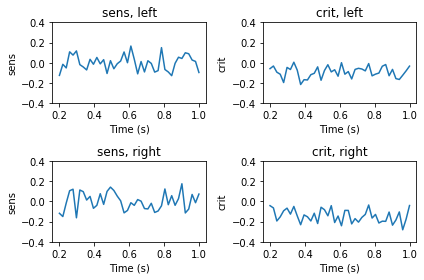

In [4]:
i_plot = 1
for ear in ('left', 'right'):
    for metric in ('sens', 'crit'):
        plt.subplot(2, 2, i_plot)
        x = d_agg[f'{metric}-{ear}']
        if metric == 'sens':  # They only detrend sensitivity
            x_plt = sm.tsa.tsatools.detrend(x, order=2)
        elif metric == 'crit':  # No detrending for criterion
            x_plt = x
        plt.plot(d_agg['t'], x_plt)
        plt.title(f'{metric}, {ear}')
        plt.ylim(-0.4, 0.4)
        plt.xlabel('Time (s)')
        plt.ylabel(metric)
        
        i_plot += 1

plt.tight_layout()

In these plots, detrended sensitivity matches what they plot in their figures. But criterion seems to be mixed up between the two ears. It's not clear where this inconsistency arises; it could appear in the labeling of the publicly-distributed data, or the plots in the original paper. However, since the current analyses are only concerned with whether we find any significant results -- regardless of where they appear -- this is not a problem for the current analysis.

Next, we can plot the spectra and determine the p-values using the 2 alternative analyses (AR surrogate and Robust est.)

 sens, left
  ar: p = 1.000
  re: p = 1.000
 crit, left
  ar: p = 0.116
  re: p = 1.000
 sens, right
  ar: p = 0.364
  re: p = 1.000
 crit, right
  ar: p = 0.134
  re: p = 1.000


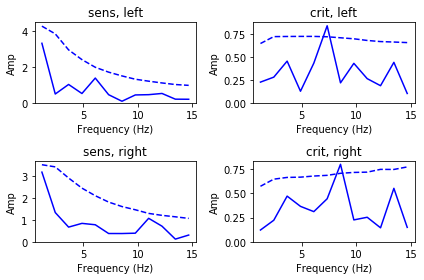

In [5]:
i_plot = 1
for ear in ('left', 'right'):
    for metric in ('sens', 'crit'):
        print(f' {metric}, {ear}')
        plt.figure('ho-spectra')
        plt.subplot(2, 2, i_plot)
        x = d_agg[f'{metric}-{ear}'].to_numpy()
        # ### TESTING - Make sure this analysis can pick up an oscillation
        # x += np.sin(2 * np.pi * 6 * np.arange(len(x)) / fs)
        for meth in ('ar', 're'):
            if meth == 'ar':  # Plot the AR surr results
                res = ar_surr(x, fs, k_perm)
                plt.plot(res['f'], res['y_emp'], '-b')
                plt.plot(res['f'],  # Uncorrected 95% CI
                         res['y_cis'][2, :],
                         '--b')
                plt.ylim(0, None)
                plt.ylabel('Amp')
                plt.xlabel('Frequency (Hz)')
            elif meth == 're':
                res = robust_est(x, fs)
            p = res['p_corr'].min()
            plt.title(f'{metric}, {ear}')
            print(f'  {meth}: p = {p:.3f}')

        i_plot += 1
plt.tight_layout()

These plots show the spectrum of the data, combined with the 95% confidence interval of the aperiodic fit to the data (uncorrected for multiple comparisons across frequencies).
The alternative analyses do not show any statistically-significant oscillations in these data.

Next, we re-analyze the sum and difference between ears for the sensitivity metric.

 sens, diff, ar: p = 0.089
 sens, sum, ar: p = 1.000
 sens, diff, re: p = 0.308
 sens, sum, re: p = 1.000


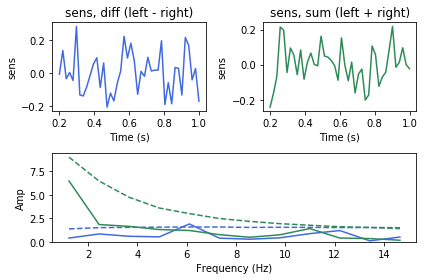

In [6]:
plt.subplot(2, 2, 1)
x_diff = d_agg[f'sens-left'] - d_agg[f'sens-right']
x_diff_plt = sm.tsa.tsatools.detrend(x_diff, order=2)
plt.plot(d_agg['t'], x_diff_plt, color='royalblue')
plt.title(f'sens, diff (left - right)')
plt.xlabel('Time (s)')
plt.ylabel('sens')
# Raw time-course: Sum
# They seem to have plotted the detrended version
plt.subplot(2, 2, 2)
x_sum = d_agg[f'sens-left'] + d_agg[f'sens-right']
x_sum_plt = sm.tsa.tsatools.detrend(x_sum, order=2)
plt.plot(d_agg['t'], x_sum_plt, color='seagreen')
plt.title(f'sens, sum (left + right)')
plt.xlabel('Time (s)')
plt.ylabel('sens')
# Spectra
plt.subplot(2, 1, 2)
for meth in ('ar', 're'):
    if meth == 'ar':
        res_diff = ar_surr(x_diff, fs, k_perm)
        res_sum = ar_surr(x_sum, fs, k_perm)
        plt.plot(res_diff['f'], res_diff['y_emp'],
                 '-', color='royalblue')
        plt.plot(res_diff['f'], res_diff['y_cis'][2, :],
                 '--', color='royalblue')
        plt.plot(res_sum['f'], res_sum['y_emp'],
                 '-', color='seagreen')
        plt.plot(res_sum['f'], res_sum['y_cis'][2, :],
                 '--', color='seagreen')
        plt.ylim(0, None)
        plt.ylabel('Amp')
        plt.xlabel('Frequency (Hz)')
        plt.tight_layout()
    elif meth == 're':
        res_diff = robust_est(x_diff, fs)
        res_sum = robust_est(x_sum, fs)

    p_diff = res_diff['p_corr'].min()
    p_sum = res_sum['p_corr'].min()
    print(f' sens, diff, {meth}: p = {p_diff:.3f}')
    print(f' sens, sum, {meth}: p = {p_sum:.3f}')


The plots of the raw time-course match the data plotted in the original paper. When the data are analyzed without shuffling in time, we see no evidence for oscillations in attention between the ears.

In [7]:
# Keep track of the results
results = results.append({'exp': 'ho_etal2017',
                          'analysis': 'ar',
                          'positive': 0,
                          'negative': 6},
                         ignore_index=True)
results = results.append({'exp': 'ho_etal2017',
                          'analysis': 're',
                          'positive': 0,
                          'negative': 6},
                         ignore_index=True)

## Davidson et al. (2018)

Davidson and colleagues tested for behavioral oscillations in attentional switching during binocular rivalry. I found 3 tests that relied on shuffling in time (Figure 3c-f).

1. Matched cues: 7.5 – 8 Hz
2. Mismatched cues: 3.3 – 3.75 Hz
3. Visual only (no cue): n.s.

In [8]:
# Load the data

# Keep track of the original results in the published paper
results = results.append({'exp': 'davidson_etal2018',
                          'analysis': 'orig',
                          'positive': 2,
                          'negative': 1},
                         ignore_index=True)

d = scipy.io.loadmat(data_dir + 'elife-40868-fig3-data1-v2.mat')
d = d['figure3c_3d_3e_sourcedata']
fs = 60  # Sampling rate given in the paper
t = np.arange(d.shape[1]) / fs
conditions = ['mismatch', 'match', 'visual only']
colors = {'mismatch': 'magenta',
          'match': 'blue',
          'visual only': 'gray'}

mismatch
 AR: p = 0.245
 RE: p = 1.000
match
 AR: p = 0.165
 RE: p = 1.000
visual only
 AR: p = 0.744
 RE: p = 1.000


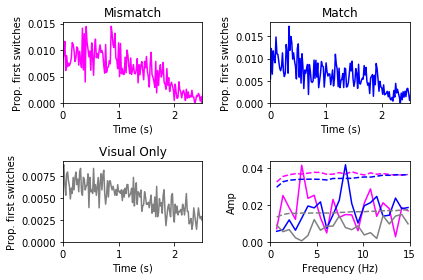

In [9]:
# Plot the raw time-series
plt.figure('davidson')
for i_cond, cond in enumerate(conditions):
    plt.subplot(2, 2, i_cond + 1)
    plt.plot(t, d[i_cond, :], color=colors[cond])
    plt.xlim(0, 2.5)
    plt.ylim(0, None)
    plt.xlabel('Time (s)')
    plt.ylabel('Prop. first switches')
    plt.title(cond.title())

# Plot the spectra and results of the AR surrogate analysis
t_sel = (0.5 < t) & (t < 2.0)  # Only look at the time window they analyze
plt.subplot(2, 2, 4)
for i_cond, cond in enumerate(conditions):
    x = d[i_cond, t_sel]
    res_ar = ar_surr(x, fs, k_perm)
    res_re = robust_est(x, fs)
    plt.plot(res_ar['f'], res_ar['y_emp'],
             '-', color=colors[cond])
    plt.plot(res_ar['f'],  # Uncorrected 95% CI
             res_ar['y_cis'][2, :],
             '--', color=colors[cond])
    p_ar = res_ar["p_corr"].min()
    p_re = res_re["p_corr"].min()
    print(f'{cond}\n AR: p = {p_ar:.3f}\n RE: p = {p_re:.3f}')
plt.ylim(0, None)
plt.xlim(0, 15)
plt.ylabel('Amp')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()


The raw time-series provided in the authors' .mat file match the unsmoothed data in the published figure, with one caveat: The data seem to have a slightly different scale and offset. For example, in the "match" time-course, the data in the .mat file reach a minimum of 0 around 2.3 s (touching the x-axis), but the data plotted in Fig 3d do not touch the x-axis at that time-point. If this is really only a difference in the offset and scaling, it won't affect the results of the spectral analysis.

These analyses show no evidence for statistically-significant oscillations in attention.

In [11]:
# Keep track of the results
results = results.append({'exp': 'davidson_etal2018',
                          'analysis': 'ar',
                          'positive': 0,
                          'negative': 3},
                         ignore_index=True)
results = results.append({'exp': 'davidson_etal2018',
                          'analysis': 're',
                          'positive': 0,
                          'negative': 3},
                         ignore_index=True)

## Senoussi et al. (2019)

Senoussi and colleagues tested for behavioral oscillations during reorienting of visual attention. They calculate “P1-P2”, a measure of how strongly attention is divided between locations. They also test for behavioral rhythms in the proportion of correct responses; specifically, they test for rhythms in the time-course of the accuracy difference between attended and unattended quadrants. They report the following statistical tests that rely on shuffling in time.

1. P1-P2, probes in opposite quadrants, valid cue (Fig. 2C): n.s.
2. P1-P2, probes in opposite quadrants, invalid cue (Fig. 2C): 3.5 – 4 Hz
3. Prop correct, attended – unattended, valid (Fig. 4C): n.s.
4. Prop correct, attended – unattended, invalid (Fig. 4D): n.s. after Bonferroni correction
5. P1-P2, probes in same quadrant, valid (Fig. 5A): n.s. after Bonferroni correction
6. P1-P2, probes in same quadrant, invalid (Fig. 5B): n.s. after Bonferroni correction
7. P1-P2, probes in same quadrant, invalid, probes in same quad as target (Fig. 5C): n.s. after Bonferroni correction
8. P1-P2, probes in same quadrant, invalid, probes in same quad as distractor (Fig. 5C): 11 Hz


Some results in the original paper are not significant after Bonferronivcorrection. This analysis does not count those as significant results.

To prepare the data for Fig 4 in the paper, run `pecar_probe_report_acc.m` from the Github repo, then run this in Matlab:

`save('results/probe_results', 'probe_results')`

Because these data involve time-courses with very few observations, the data must be zero-padded to compute the multitaper spectra for the robust est. analysis.

In [12]:
# Load the data

# Keep track of the original results
results = results.append({'exp': 'senoussi_etal2019',
                          'analysis': 'orig',
                          'positive': 2,
                          'negative': 6},
                         ignore_index=True)

exp_dir = 'PECAR-master/results/'
t = np.arange(40, 520 + 1, 40)  # Time variable in ms
fs = np.mean(np.diff(t / 1000)) ** -1

Val:1
 AR: p = 1.000
 RE: p = 0.223
Val:0
 AR: p = 0.330
 RE: p = 1.000


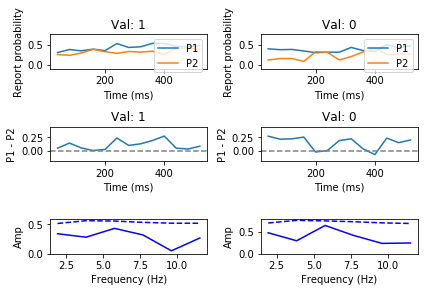

In [13]:
# Reproduce the analyses in Fig 3
fn = exp_dir + '11obs_P1_P2_Delta_byvalidity_bycongrus_onlycorrect'
d = scipy.io.loadmat(data_dir + fn)
P1 = d['P1_all']  # Dims: time, validity, congruity, subject
P2 = d['P2_all']
P1 = np.mean(P1, axis=-1)
P2 = np.mean(P2, axis=-1)
Pdiff = P1 - P2
i_cong = 0  # Pre-probe congruity
plt.figure('senoussi-fig3')
i_plot = 1
for i_val in [1, 0]:
    # Plot the time-series
    plt.subplot(3, 2, i_plot)
    plt.plot(t, P1[:, i_val, i_cong], label='P1')
    plt.plot(t, P2[:, i_val, i_cong], label='P2')
    plt.title(f"Val: {i_val}")
    plt.ylim(-0.1, 0.75)
    plt.ylabel('Report probability')
    plt.xlabel('Time (ms)')
    plt.legend()

    plt.subplot(3, 2, i_plot + 2)
    x = Pdiff[:, i_val, i_cong]
    plt.plot(t, x)
    plt.axhline(y=0, linestyle='--', color='grey')
    plt.title(f"Val: {i_val}")
    plt.ylim(-0.2, 0.45)
    plt.ylabel('P1 - P2')
    plt.xlabel('Time (ms)')

    # Look at spectra
    res_ar = ar_surr(x, fs, k_perm)
    # Data too short for multitaper est (the Fortran routines throw an
    # error), so I'm padding the data just enough to let those functions
    # return without crashing.
    x_re = np.pad(x, 5, mode='mean')
    res_re = robust_est(x_re, fs)
    plt.subplot(3, 2, i_plot + 4)
    plt.plot(res_ar['f'], res_ar['y_emp'], '-b')
    plt.plot(res_ar['f'],  # Uncorrected 95% CI
             res_ar['y_cis'][2, :],
             '--b')
    plt.ylim(0, None)
    plt.ylabel(f'Amp')
    plt.xlabel('Frequency (Hz)')
    p_ar = res_ar["p_corr"].min()
    p_re = res_re["p_corr"].min()
    print(f'Val:{i_val}\n AR: p = {p_ar:.3f}\n RE: p = {p_re:.3f}')

    i_plot += 1
plt.tight_layout()


Val:0, Cong:0
 AR: p = 1.000
 RE: p = 1.000
Val:1, Cong:0
 AR: p = 0.106
 RE: p = 1.000


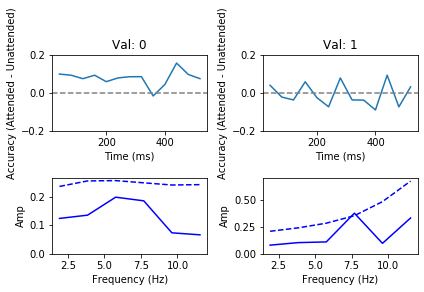

In [14]:
# Fig 4
fn = "probe_results.mat"  # Saved after running pecar_probe_report_acc.m
d = scipy.io.loadmat(data_dir + exp_dir + fn)['probe_results']
d = np.mean(d[:, 0, :, :] - d[:, 1, :, :], axis=0)
plt.figure('senoussi-fig4')
for i_val in [0, 1]:

    # Plot the time-series
    x = d[i_val, :]
    plt.subplot(2, 2, i_val + 1)
    plt.plot(t, x)
    plt.axhline(y=0, linestyle='--', color='grey')
    plt.title(f"Val: {i_val}")
    plt.ylim(-0.2, 0.2)
    plt.ylabel('Accuracy (Attended - Unattended)')
    plt.xlabel('Time (ms)')

    # Look at spectra
    res_ar = ar_surr(x, fs, k_perm)
    x_re = np.pad(x, 5, mode='mean')  # Pad to allow for multitapers
    res_re = robust_est(x_re, fs)
    del x
    plt.subplot(2, 2, i_val + 3)
    plt.plot(res_ar['f'], res_ar['y_emp'], '-b')
    plt.plot(res_ar['f'],  # Uncorrected 95% CI
             res_ar['y_cis'][2, :],
             '--b')
    plt.ylim(0, None)
    plt.ylabel(f'Amp')
    plt.xlabel('Frequency (Hz)')
    p_ar = res_ar["p_corr"].min()
    p_re = res_re["p_corr"].min()
    print(f'Val:{i_val}, Cong:{i_cong}\n'
          f' AR: p = {p_ar:.3f}\n'
          f' RE: p = {p_re:.3f}')

plt.tight_layout()

All these traces match the data plotted in the original paper.

However, these analyses show no evidence of oscillations in attention.

In [15]:
# Keep track of the results
results = results.append({'exp': 'senoussi_etal2019',
                          'analysis': 'ar',
                          'positive': 0,
                          'negative': 8},
                         ignore_index=True)
results = results.append({'exp': 'senoussi_etal2019',
                          'analysis': 're',
                          'positive': 0,
                          'negative': 8},
                         ignore_index=True)

##  Michel et al. (2021) 
Michel and colleagues tested for behavioral rhythms in a visual continuous-report task. They used mixture models to separately estimate fluctuations in spatial precision (“sd”) and the likelihood that participants were guessing (“g”). The following results relied on shuffling in time.
    1. g, valid cue: n.s.
    2. g, invalid cue: n.s.
    3. g, collapsed: 4.8 Hz
    4. sd, valid: n.s.
    5. sd, invalid: 9.6 Hz
    6. sd, collapsed: n.s.

In [16]:
# Load the data

# Keep track of original results
results = results.append({'exp': 'michel_etal2021',
                          'analysis': 'orig',
                          'positive': 2,
                          'negative': 4},
                         ignore_index=True)

# Load and prep data grouped by validity
data_val = pyreadr.read_r(data_dir + 'RAPdata/mm_data.Rdata')
data_val = data_val['data']
avg_val = (
    data_val
    .groupby(['validity', 'soa'], as_index=False)
    .agg(np.mean)
    .astype({'soa': np.float64})
    )

# Load and prep data collapsed over validity
data_col = pyreadr.read_r(data_dir + 'RAPdata/mm_data_acrossval.Rdata')
data_col = data_col['data']
avg_col = (
    data_col
    .groupby(['soa'], as_index=False)
    .agg(np.mean)
    .astype({'soa': np.float64})
    )

colors = {'valid': 'tab:blue',
          'invalid': 'tab:orange'}

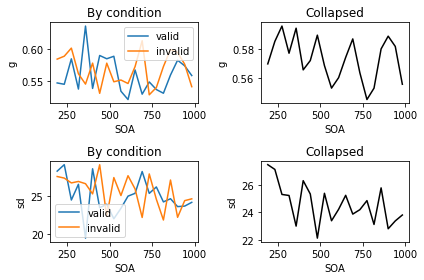

In [17]:
# Plot the time-courses
for i_meas, meas in enumerate(['g', 'sd']):
    plt.subplot(2, 2, 1 + (2 * i_meas))
    for cond in ('valid', 'invalid'):
        df = avg_val.loc[avg_val['validity'] == cond]
        plt.plot(df['soa'], df[meas],
                 color=colors[cond], label=cond)
    plt.legend()
    plt.ylabel(meas)
    plt.xlabel('SOA')
    plt.title('By condition')

    plt.subplot(2, 2, 2 + (2 * i_meas))
    plt.plot(avg_col['soa'], avg_col[meas], '-k', label=cond)
    plt.ylabel(meas)
    plt.xlabel('SOA')
    plt.title('Collapsed')

plt.tight_layout()


The data time-courses match the time-courses shown in the paper.

g, valid
 AR: p = 1.000
 RE: p = 1.000
g, invalid
 AR: p = 0.205
 RE: p = 1.000
g, collapsed
 AR: p = 0.069
 RE: p = 1.000
sd, valid
 AR: p = 1.000
 RE: p = 1.000
sd, invalid
 AR: p = 0.282
 RE: p = 0.812
sd, collapsed
 AR: p = 0.396
 RE: p = 1.000


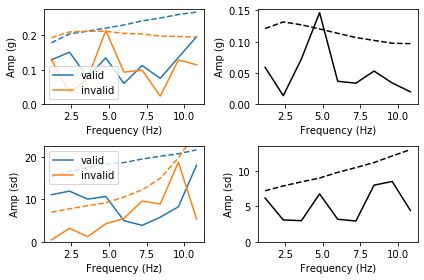

In [18]:
# Compute and plot the spectra and results of the AR surrogate analysis
samp_period = 0.04165  # in seconds, from the paper
fs = samp_period ** -1
assert np.isclose(fs,  # Make sure the samp rate matches the data
                  np.mean(np.diff(avg_col['soa']) / 1000) ** -1,
                  rtol=1e-3)

for i_meas, meas in enumerate(['g', 'sd']):
    plt.subplot(2, 2, 1 + (i_meas * 2))
    for cond in ('valid', 'invalid'):
        df = avg_val.loc[avg_val['validity'] == cond]
        x = df[meas].to_numpy()
        res_ar = ar_surr(x, fs, k_perm)
        res_re = robust_est(x, fs)
        plt.plot(res_ar['f'], res_ar['y_emp'],
                 '-', color=colors[cond],
                 label=cond)
        plt.plot(res_ar['f'],  # Uncorrected 95% CI
                 res_ar['y_cis'][2, :],
                 '--', color=colors[cond])
        plt.ylim(0, None)
        plt.ylabel(f'Amp ({meas})')
        plt.xlabel('Frequency (Hz)')
        p_ar = res_ar["p_corr"].min()
        p_re = res_re["p_corr"].min()
        print(f'{meas}, {cond}\n AR: p = {p_ar:.3f}\n RE: p = {p_re:.3f}')
    plt.legend()
    
    plt.subplot(2, 2, 2 + (i_meas * 2))
    x = avg_col[meas].to_numpy()
    #  ## TESTING - add an artificial oscillation
    # x += 2 * np.sin(2 * np.pi * 6 * np.arange(len(x)) / fs)
    res_ar = ar_surr(x, fs, k_perm)
    res_re = robust_est(x, fs)
    plt.plot(res_ar['f'], res_ar['y_emp'], '-k')
    plt.plot(res_ar['f'],  # Uncorrected 95% CI
             res_ar['y_cis'][2, :],
             '--k')
    plt.ylim(0, None)
    plt.ylabel(f'Amp ({meas})')
    plt.xlabel('Frequency (Hz)')
    p_ar = res_ar["p_corr"].min()
    p_re = res_re["p_corr"].min()
    print(f'{meas}, collapsed\n AR: p = {p_ar:.3f}\n RE: p = {p_re:.3f}')

plt.tight_layout()

These analyses show no significant oscillations. One test is marginal (p < .1) when analyzed with the AR surrogate method, but non-significant when analyzed with the Robust est. method.

In [19]:
# Keep track of the results
results = results.append({'exp': 'michel_etal2021',
                          'analysis': 'ar',
                          'positive': 0,
                          'negative': 6},
                         ignore_index=True)
results = results.append({'exp': 'michel_etal2021',
                          'analysis': 're',
                          'positive': 0,
                          'negative': 6},
                         ignore_index=True)

## Aggregate analyses

I then plotted the total number of statistically significant and non-significant results reported in the original studies, and compared the original results with results obtained by the AR surrogate and robust est. methods.

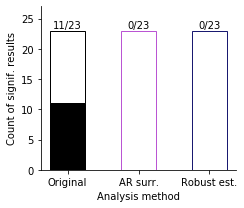

In [20]:
plt.figure('aggregate', figsize=(3.5, 3))
ax = plt.gca()

res = results.groupby('analysis', sort=False).agg(np.sum)

colors = ['black', 'mediumorchid', 'midnightblue']
labels = ['Original', 'AR surr.', 'Robust est.']
ax.bar(labels, res['positive'],
       width=0.5, color=colors, edgecolor=colors,
       label='Positive result')
ax.bar(labels, res['negative'], bottom=res['positive'],
       width=0.5, color='white', edgecolor=colors,
       label='Negative result')
# Add text labels to the tops of the bars
for i_bar in range(res.shape[0]):
    pos = res['positive'].iloc[i_bar]
    neg = res['negative'].iloc[i_bar]
    plt.text(i_bar, pos + neg,
             f'{pos}/{pos+neg}',
             horizontalalignment='center',
             verticalalignment='bottom')

plt.xlabel('Analysis method')
plt.ylabel('Count of signif. results')
y_max = int(res[['positive', 'negative']].sum(axis=1).max() * 1.2)
plt.ylim(0, y_max)
plt.yticks(np.arange(0, y_max, 5))

# Remove the top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{plot_dir}external_datasets.eps')

## References

Davidson, M. J., Alais, D., van Boxtel, J. J., & Tsuchiya, N. (2018). Attention periodically samples competing stimuli during binocular rivalry. Elife, 7, e40868.

Ho, H. T., Leung, J., Burr, D. C., Alais, D., & Morrone, M. C. (2017). Auditory sensitivity and decision criteria oscillate at different frequencies separately for the two ears. Current Biology, 27(23), 3643-3649.

Michel, R., Dugué, L., & Busch, N. A. (2021). Distinct contributions of alpha and theta rhythms to perceptual and attentional sampling. European Journal of Neuroscience.

Senoussi, M., Moreland, J. C., Busch, N. A., & Dugué, L. (2019). Attention explores space periodically at the theta frequency. Journal of Vision, 19(5), 22-22.